In [1]:
# Core utilities moved to fire_model package
import numpy as np
import matplotlib.pyplot as plt
from fire_model.ca import FireEnv, FireState, CAFireModel
from fire_model.boundary import (
    FireBoundary,
    between_boundaries_mask,
    candidates_from_mask,
    extract_fire_boundary,
    plot_fire_boundary,
)
from fire_model.harmonic import (
    HarmonicStripMap,
    BoundaryMap,
    build_harmonic_strip_map_uniform,
    plot_strip_map,
    sd_to_xy_theta,
    build_boundary_map,
    plot_boundary_correspondence,
)
from fire_model.bo import (
    RetardantDropBayesOpt,
    SearchGridProjector,
    TiedXYFiMatern,
    expected_improvement,
)

import fire_model.bo as bo

### Environment Set-Up

In [2]:
# Grid / domain
nx = ny = 150
domain_km = 5

# Time discretisation (used for indexing time-varying wind and for FireState.t)
dt_s = 5.0

# Fire physics parameters
burn_time_s0 = 15 * 60         # how long a cell stays "burning" after ignition (seconds)
ros_mps = 0.2                 # baseline ROS (m/s)

# Retardant parameters
retardant_half_life_s = 2400.0 # seconds (e.g., 40 minutes)
retardant_k = 1.25             # attenuation strength exp(-k * retardant)

# Spatial maps
xs = np.linspace(-1.0, 1.0, nx)[:, None]
ys = np.linspace(-1.0, 1.0, ny)[None, :]
fuel = 0.7 + 0.9 * np.exp(-3.0 * (xs**2 + ys**2))
value = 1.0 + 3.0 * np.exp(-4.0 * ((xs - 0.2) ** 2 + (ys + 0.1) ** 2))

# Constant wind: mild south-westerly
wind=np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = -3
wind[..., 1] = -3

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    wind=wind,
    fuel=fuel,
    value=value,
    dt_s=dt_s,
    burn_time_s0=burn_time_s0,
    retardant_half_life_s=retardant_half_life_s,
    retardant_k=retardant_k,
    ros_mps=ros_mps,
    # wind_coeff is unused by the Finsler model, but can exist in the env
    wind_coeff=0.6,
    diag=True,
)

ca_model = CAFireModel(env,seed=42)

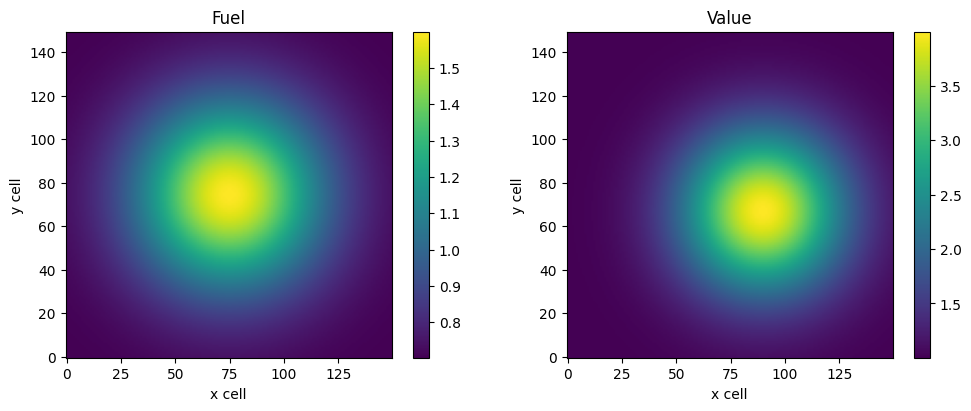

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

im0 = ax[0].imshow(fuel.T, origin="lower", aspect="equal")
ax[0].set_title("Fuel")
ax[0].set_xlabel("x cell"); ax[0].set_ylabel("y cell")
fig.colorbar(im0, ax=ax[0], fraction=0.046)

im1 = ax[1].imshow(value.T, origin="lower", aspect="equal")
ax[1].set_title("Value")
ax[1].set_xlabel("x cell"); ax[1].set_ylabel("y cell")
fig.colorbar(im1, ax=ax[1], fraction=0.046)

plt.show()

### Ignition and Search Domain

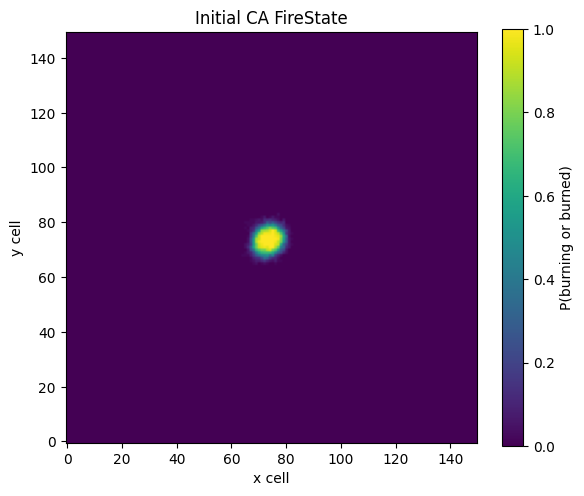

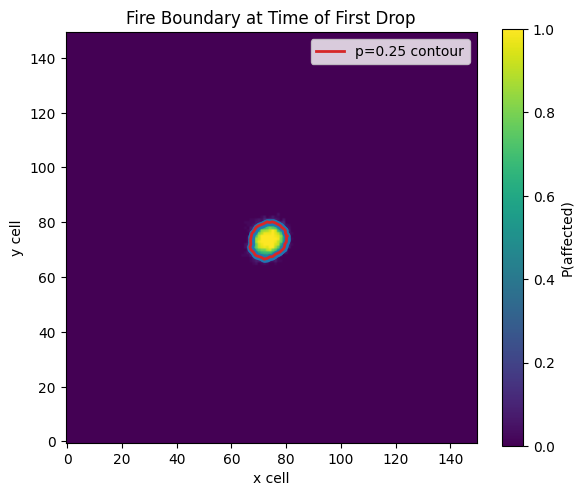

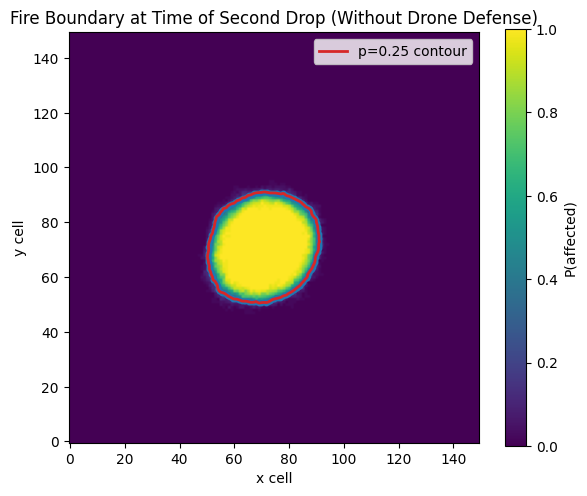

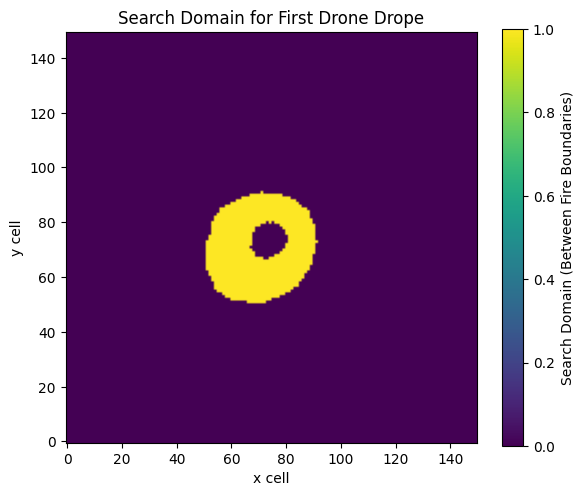

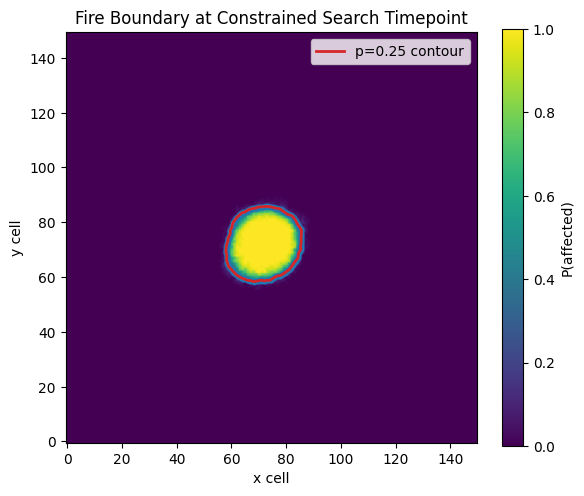

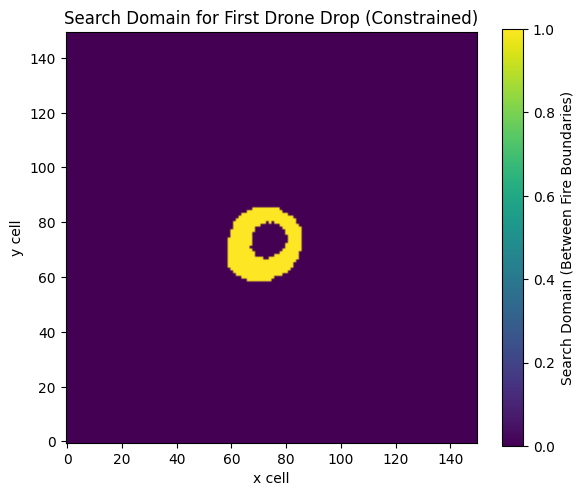

In [3]:
# Ignition and time until drones reach the fire
ignition_center = (nx // 2, ny // 2)
ignition_radius_km = 0.01
time_to_first_drop = 60.0  # 1 minute to response
time_to_second_drop = 180.0 # 2 minutes later 
search_space_time = (time_to_second_drop - time_to_first_drop)//2

# Initial Evolution
init_firestate_ca = ca_model.simulate_from_ignition(
    center=ignition_center,
    radius_km=ignition_radius_km,
    n_sims=50,
    T=time_to_first_drop
)

ca_model.plot_firestate(init_firestate_ca,title="Initial CA FireState")

# Visualising the boundary
init_boundary = extract_fire_boundary(
    init_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    init_firestate_ca,
    init_boundary,
    field="affected",
    title="Fire Boundary at Time of First Drop"
)

# Visualising the search domain
second_firestate_ca = ca_model.simulate_from_firestate(
    init_firestate=init_firestate_ca,
    T=time_to_second_drop - time_to_first_drop, # assumes we want to search the whole space between first & second drop (smaller might be better in practice)
    n_sims=50,
)

second_boundary = extract_fire_boundary(
    second_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    second_firestate_ca,
    second_boundary,
    field="affected",
    title="Fire Boundary at Time of Second Drop (Without Drone Defense)"
)

between_boundaries_mask = ca_model.discretise_between_boundaries(init_boundary, second_boundary)

ca_model.plot_search_domain(between_boundaries_mask,title="Search Domain for First Drone Drope")

# Extra constrained search space

constrained_firestate_ca = ca_model.simulate_from_firestate(
    init_firestate=init_firestate_ca,
    T=search_space_time, # assumes we want to search the whole space between first & second drop (smaller might be better in practice)
    n_sims=50,
)

constrained_boundary = extract_fire_boundary(
    constrained_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    constrained_firestate_ca,
    constrained_boundary,
    field="affected",
    title="Fire Boundary at Constrained Search Timepoint"
)

between_boundaries_mask = ca_model.discretise_between_boundaries(init_boundary, constrained_boundary)

ca_model.plot_search_domain(between_boundaries_mask,title="Search Domain for First Drone Drop (Constrained)")

### Bayesian Optimisation Set-Up

In [4]:
from fire_model.bo import RetardantDropBayesOpt

constrained_search_time = (time_to_second_drop - time_to_first_drop)*2//3

drop_opt = RetardantDropBayesOpt(
    fire_model=ca_model,
    init_firestate=init_firestate_ca,
    n_drones=4,
    evolution_time_s=time_to_second_drop-time_to_first_drop,
    search_grid_evolution_time_s=constrained_search_time,
    n_sims=50,
    fire_boundary_probability=0.5,
)

### Bayesian Optimisation (Random Mask Initialisation)

In [5]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12,
    xi=0.01, 
    verbose=True,
    init_strategy="random_mask",
    candidate_strategy="qmc",
    candidate_qmc="sobol",
    print_every=10,
)

[BO] init: n_init=50, dim=12, n_cells=267
[BO] init: best_y=1.19665, mean_y=1.39149, std_y=0.105121


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 001/150 | y_next=1.54213 | best_y=1.19665 (no-improve) | EI_max=0.0048 | mu=1.30482 | std=0.0946
      proposed (x,y,phi) per drone:
      [[61.         68.          0.14963011]
 [61.         68.          5.0249372 ]
 [68.         62.          0.92242526]
 [70.         83.          0.6411628 ]]
      gp.kernel_ = 0.736**2 * TiedXYFiMatern(lx=35.6, ly=0.0733, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.601)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packa

[BO] iter 010/150 | y_next=1.54901 | best_y=1.19665 (no-improve) | EI_max=0.00335 | mu=1.35839 | std=0.114
      proposed (x,y,phi) per drone:
      [[65.         79.          3.61102279]
 [77.         82.          4.21237081]
 [82.         69.          0.13519085]
 [82.         73.          2.06452976]]
      gp.kernel_ = 0.999**2 * TiedXYFiMatern(lx=0.0406, ly=635, lphi=0.417, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packa

[BO] iter 020/150 | y_next=1.46609 | best_y=1.19665 (no-improve) | EI_max=0.00385 | mu=1.3383 | std=0.107
      proposed (x,y,phi) per drone:
      [[6.20000000e+01 7.50000000e+01 4.36368814e+00]
 [6.80000000e+01 6.20000000e+01 2.54742489e-02]
 [7.40000000e+01 6.20000000e+01 3.42050558e+00]
 [8.20000000e+01 7.60000000e+01 4.00942808e+00]]
      gp.kernel_ = 0.596**2 * TiedXYFiMatern(lx=17.5, ly=0.107, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.774)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 030/150 | y_next=1.33022 | best_y=1.19665 (no-improve) | EI_max=0.00262 | mu=1.35137 | std=0.105
      proposed (x,y,phi) per drone:
      [[61.         68.          0.33306378]
 [74.         62.          2.44389418]
 [77.         64.          1.13041868]
 [77.         64.          1.44963108]]
      gp.kernel_ = 0.541**2 * TiedXYFiMatern(lx=76.6, ly=0.103, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.812)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 040/150 | y_next=1.37623 | best_y=1.19665 (no-improve) | EI_max=0.00196 | mu=1.36233 | std=0.104
      proposed (x,y,phi) per drone:
      [[62.         75.          2.47030221]
 [68.         62.          0.37256622]
 [68.         62.          3.78169041]
 [82.         74.          5.10953962]]
      gp.kernel_ = 0.48**2 * TiedXYFiMatern(lx=114, ly=0.101, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.858)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 050/150 | y_next=1.4897 | best_y=1.19665 (no-improve) | EI_max=0.00233 | mu=1.34905 | std=0.101
      proposed (x,y,phi) per drone:
      [[63.         77.          3.83174356]
 [68.         62.          3.1158479 ]
 [74.         62.          3.70416694]
 [80.         80.          1.65745669]]
      gp.kernel_ = 0.546**2 * TiedXYFiMatern(lx=112, ly=0.109, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.837)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 060/150 | y_next=1.26469 | best_y=1.19665 (no-improve) | EI_max=0.00549 | mu=1.29798 | std=0.0942
      proposed (x,y,phi) per drone:
      [[68.         82.          4.55662549]
 [71.         62.          1.18084358]
 [76.         63.          5.00083341]
 [82.         69.          2.83363635]]
      gp.kernel_ = 1**2 * TiedXYFiMatern(lx=0.0328, ly=0.042, lphi=1.38, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 070/150 | y_next=1.31848 | best_y=1.19665 (no-improve) | EI_max=0.00545 | mu=1.29651 | std=0.0931
      proposed (x,y,phi) per drone:
      [[62.         75.          5.83585378]
 [76.         63.          0.49872282]
 [76.         63.          5.3796059 ]
 [77.         82.          0.55169525]]
      gp.kernel_ = 1.02**2 * TiedXYFiMatern(lx=0.0401, ly=0.0463, lphi=1.88, nu=2.5) + WhiteKernel(noise_level=1.82e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 080/150 | y_next=1.31765 | best_y=1.1896 (no-improve) | EI_max=0.00684 | mu=1.26042 | std=0.0813
      proposed (x,y,phi) per drone:
      [[62.         66.          0.21703239]
 [63.         77.          1.85648789]
 [74.         62.          2.5406561 ]
 [81.         79.          2.57744946]]
      gp.kernel_ = 1.02**2 * TiedXYFiMatern(lx=0.0491, ly=0.0502, lphi=1.65, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 090/150 | y_next=1.1855 | best_y=1.16309 (no-improve) | EI_max=0.00489 | mu=1.25288 | std=0.0843
      proposed (x,y,phi) per drone:
      [[68.         62.          0.56847159]
 [68.         82.          2.22916032]
 [76.         63.          2.26575804]
 [81.         79.          3.49006659]]
      gp.kernel_ = 0.983**2 * TiedXYFiMatern(lx=0.125, ly=0.0624, lphi=1.49, nu=2.5) + WhiteKernel(noise_level=0.086)
[BO] iter 100/150 | y_next=1.19273 | best_y=1.16309 (no-improve) | EI_max=0.00413 | mu=1.29002 | std=0.101
      proposed (x,y,phi) per drone:
      [[68.         62.          0.95288862]
 [70.         83.          2.67340897]
 [76.         63.          5.56587671]
 [82.         76.          3.7224251 ]]
      gp.kernel_ = 1.02**2 * TiedXYFiMatern(lx=0.0701, ly=0.06, lphi=1.54, nu=2.5) + WhiteKernel(noise_level=5e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 110/150 | y_next=1.21688 | best_y=1.14746 (no-improve) | EI_max=0.00237 | mu=1.24508 | std=0.0737
      proposed (x,y,phi) per drone:
      [[68.         62.          0.76476993]
 [70.         83.          2.35863964]
 [74.         62.          6.14301173]
 [81.         79.          3.25395561]]
      gp.kernel_ = 0.957**2 * TiedXYFiMatern(lx=0.147, ly=0.0607, lphi=1.56, nu=2.5) + WhiteKernel(noise_level=0.116)
[BO] iter 120/150 | y_next=1.31175 | best_y=1.1464 (no-improve) | EI_max=0.00282 | mu=1.25744 | std=0.0841
      proposed (x,y,phi) per drone:
      [[68.         62.          1.47982107]
 [68.         82.          1.51713155]
 [74.         62.          5.72681913]
 [82.         73.          3.06138073]]
      gp.kernel_ = 0.943**2 * TiedXYFiMatern(lx=0.0771, ly=0.069, lphi=1.77, nu=2.5) + WhiteKernel(noise_level=0.161)
[BO] iter 130/150 | y_next=1.24362 | best_y=1.1464 (no-improve) | EI_max=0.0031 | mu=1.2392 | std=0.0761
      proposed (x,y,phi) per drone:
      [[62

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 150/150 | y_next=1.22469 | best_y=1.1464 (no-improve) | EI_max=0.00185 | mu=1.3137 | std=0.104
      proposed (x,y,phi) per drone:
      [[61.         68.          5.41986211]
 [62.         66.          1.46034979]
 [62.         75.          2.42683917]
 [82.         69.          2.40397303]]
      gp.kernel_ = 0.957**2 * TiedXYFiMatern(lx=0.0825, ly=0.074, lphi=1.57, nu=2.5) + WhiteKernel(noise_level=0.141)
[BO] done: best_y=1.1464
[BO] best params:
[[66.         63.          1.84133156]
 [68.         82.          2.76135477]
 [71.         62.          5.42876491]
 [81.         79.          3.77034245]]


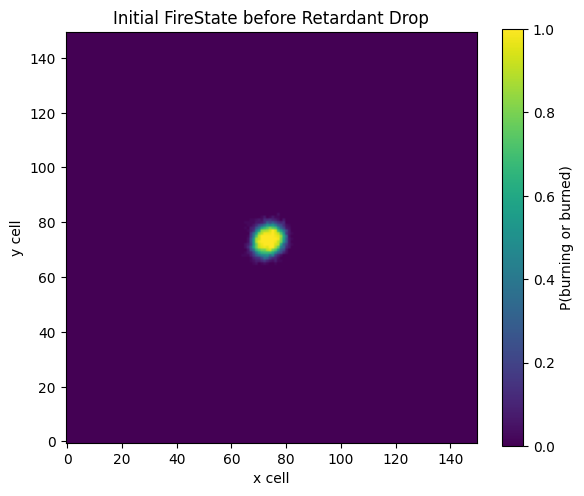

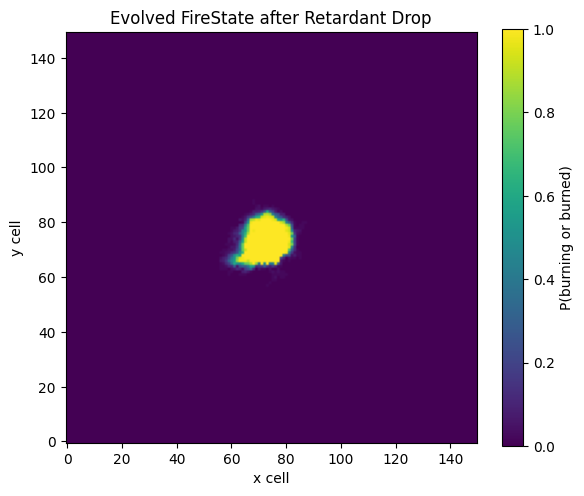

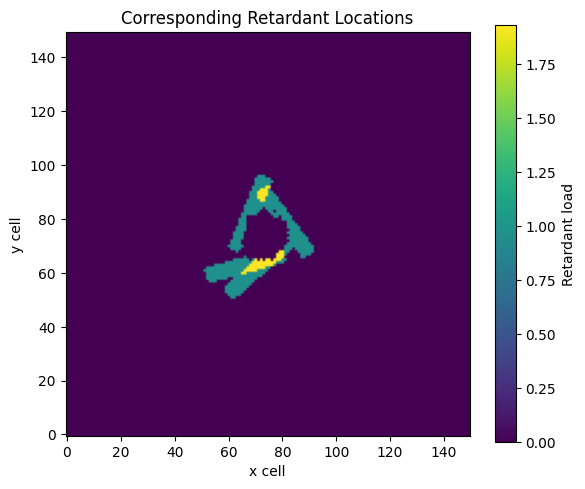

In [6]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

### Bayesian Optimisation (Heuristic + Random Initialisation)

In [7]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12,
    xi=0.01, 
    verbose=True,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.3, #% of initial points that are random (the rest are heuristic initialised)
    print_every=10,
    candidate_strategy="qmc",
    candidate_qmc="sobol",
)

[BO] init: n_init=50, dim=12, n_cells=267
[BO] init: best_y=1.17493, mean_y=1.35918, std_y=0.123008
[BO] iter 001/150 | y_next=1.33653 | best_y=1.17493 (no-improve) | EI_max=0.0183 | mu=1.2144 | std=0.0954
      proposed (x,y,phi) per drone:
      [[64.         78.          3.88587262]
 [66.         63.          1.88835825]
 [74.         62.          1.62521842]
 [81.         79.          6.05704098]]
      gp.kernel_ = 1.19**2 * TiedXYFiMatern(lx=0.0791, ly=0.103, lphi=2.38, nu=2.5) + WhiteKernel(noise_level=0.0195)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 010/150 | y_next=1.50516 | best_y=1.17493 (no-improve) | EI_max=0.0188 | mu=1.21425 | std=0.0968
      proposed (x,y,phi) per drone:
      [[68.         62.          3.28971174]
 [70.         83.          1.37692638]
 [70.         83.          2.0680691 ]
 [77.         82.          2.33575402]]
      gp.kernel_ = 1.16**2 * TiedXYFiMatern(lx=0.0531, ly=53.3, lphi=1.78, nu=2.5) + WhiteKernel(noise_level=0.0317)
[BO] iter 020/150 | y_next=1.3016 | best_y=1.17493 (no-improve) | EI_max=0.00726 | mu=1.25312 | std=0.0878
      proposed (x,y,phi) per drone:
      [[62.         75.          3.94742445]
 [68.         62.          1.94370832]
 [74.         83.          1.42652913]
 [81.         79.          1.34040318]]
      gp.kernel_ = 1.15**2 * TiedXYFiMatern(lx=0.0555, ly=0.121, lphi=2.48, nu=2.5) + WhiteKernel(noise_level=0.0313)
[BO] iter 030/150 | y_next=1.4979 | best_y=1.17493 (no-improve) | EI_max=0.00319 | mu=1.3064 | std=0.0975
      proposed (x,y,phi) per drone:
      [[63.

/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 040/150 | y_next=1.35942 | best_y=1.17493 (no-improve) | EI_max=0.00231 | mu=1.26882 | std=0.0713
      proposed (x,y,phi) per drone:
      [[62.         75.          2.47376925]
 [63.         77.          2.33059858]
 [66.         63.          2.35758372]
 [74.         62.          1.86271372]]
      gp.kernel_ = 1.21**2 * TiedXYFiMatern(lx=1e+03, ly=0.214, lphi=3.48, nu=2.5) + WhiteKernel(noise_level=0.354)
[BO] iter 050/150 | y_next=1.34904 | best_y=1.17493 (no-improve) | EI_max=0.00362 | mu=1.27155 | std=0.0814
      proposed (x,y,phi) per drone:
      [[62.         66.          2.65289457]
 [68.         62.          1.90647335]
 [72.         83.          3.42337409]
 [80.         80.          2.54197379]]
      gp.kernel_ = 1.16**2 * TiedXYFiMatern(lx=0.0514, ly=0.141, lphi=2.26, nu=2.5) + WhiteKernel(noise_level=0.0423)
[BO] iter 060/150 | y_next=1.17874 | best_y=1.17493 (no-improve) | EI_max=0.00312 | mu=1.2711 | std=0.0781
      proposed (x,y,phi) per drone:
      [[6

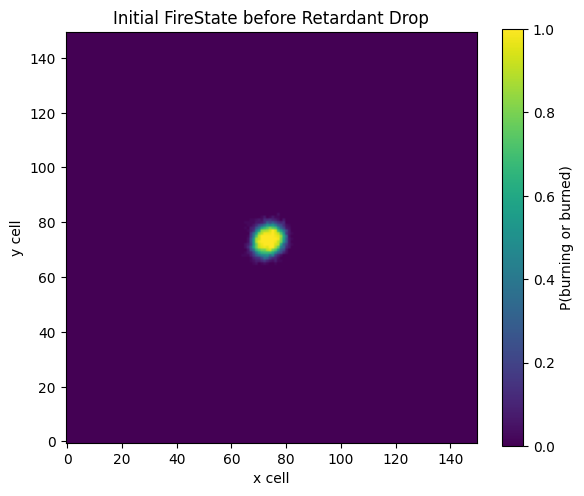

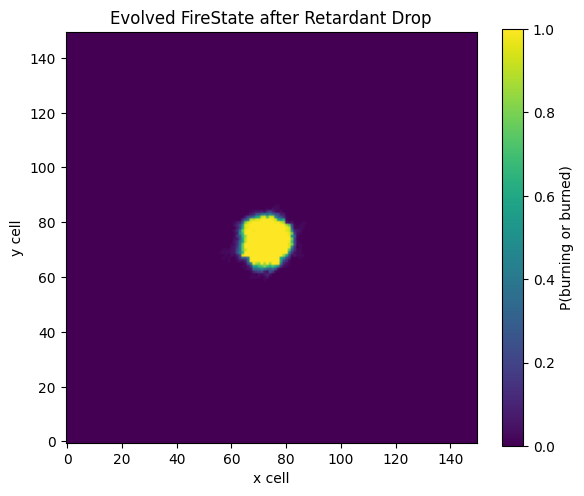

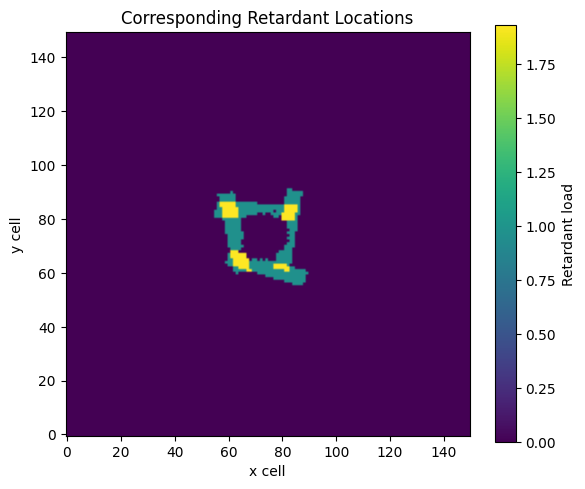

In [8]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

### Heuristic + Local Exploitation

In [9]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12, #note will still hit the Sobol balance property warning since Sobol used for global (so n_candidates*(1-candidate_local_frac) should be power of 2)
    xi=0.01, 
    verbose=True,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.3, #% of initial points that are random (the rest are heuristic initialised)
    print_every=10,
    candidate_strategy="mixed",
    candidate_qmc="sobol",
    candidate_local_frac=0.6,
    candidate_local_top_k=5,
    candidate_local_sigma_cells=4.0,
    candidate_local_sigma_phi_rad=np.deg2rad(20),
)

[BO] init: n_init=50, dim=12, n_cells=267
[BO] init: best_y=1.18565, mean_y=1.33862, std_y=0.0978746


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


[BO] iter 001/150 | y_next=1.21518 | best_y=1.18565 (no-improve) | EI_max=0.0313 | mu=1.16629 | std=0.0662
      proposed (x,y,phi) per drone:
      [[62.         74.          2.98110033]
 [63.         70.          3.24604802]
 [67.         65.          1.58607008]
 [71.         62.          2.16769418]]
      gp.kernel_ = 1.06**2 * TiedXYFiMatern(lx=1e+03, ly=0.0595, lphi=1.46, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda

[BO] iter 010/150 | y_next=1.35196 | best_y=1.17681 (no-improve) | EI_max=0.0133 | mu=1.20661 | std=0.0725
      proposed (x,y,phi) per drone:
      [[65.         74.          3.05725984]
 [67.         64.          2.51261092]
 [67.         80.          3.30479063]
 [72.         62.          2.53331398]]
      gp.kernel_ = 1.04**2 * TiedXYFiMatern(lx=0.0628, ly=0.0434, lphi=2.26, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda

[BO] iter 020/150 | y_next=1.14578 | best_y=1.14578 (improved) | EI_max=0.0082 | mu=1.17121 | std=0.0487
      proposed (x,y,phi) per drone:
      [[63.         74.          2.7088353 ]
 [66.         71.          2.95358311]
 [72.         64.          1.62676906]
 [73.         67.          2.03526936]]
      gp.kernel_ = 1.03**2 * TiedXYFiMatern(lx=251, ly=0.049, lphi=1.07, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda

[BO] iter 030/150 | y_next=1.26871 | best_y=1.13796 (no-improve) | EI_max=0.00313 | mu=1.28505 | std=0.105
      proposed (x,y,phi) per drone:
      [[63.         77.          2.43008574]
 [72.         68.          3.05961853]
 [76.         63.          1.50666189]
 [80.         67.          5.66044818]]
      gp.kernel_ = 1.05**2 * TiedXYFiMatern(lx=381, ly=0.0626, lphi=1.09, nu=2.5) + WhiteKernel(noise_level=0.00373)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lphi is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sa

[BO] iter 040/150 | y_next=1.20362 | best_y=1.13631 (no-improve) | EI_max=0.0108 | mu=1.15737 | std=0.0578
      proposed (x,y,phi) per drone:
      [[62.         73.          3.51560541]
 [68.         75.          2.84708024]
 [70.         62.          1.58258448]
 [80.         67.          5.81207476]]
      gp.kernel_ = 1.05**2 * TiedXYFiMatern(lx=381, ly=0.0501, lphi=1.32, nu=2.5) + WhiteKernel(noise_level=0.0258)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = 

[BO] iter 050/150 | y_next=1.21906 | best_y=1.13631 (no-improve) | EI_max=0.00582 | mu=1.19221 | std=0.0673
      proposed (x,y,phi) per drone:
      [[62.         73.          2.9436538 ]
 [63.         77.          3.1172266 ]
 [79.         66.          1.45531492]
 [80.         67.          4.89689892]]
      gp.kernel_ = 1.04**2 * TiedXYFiMatern(lx=433, ly=0.0571, lphi=1.7, nu=2.5) + WhiteKernel(noise_level=0.111)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 060/150 | y_next=1.42997 | best_y=1.12405 (no-improve) | EI_max=0.00296 | mu=1.30305 | std=0.12
      proposed (x,y,phi) per drone:
      [[68.         62.          0.25228904]
 [68.         82.          3.28762176]
 [70.         83.          5.39487772]
 [74.         62.          3.43654082]]
      gp.kernel_ = 1.06**2 * TiedXYFiMatern(lx=245, ly=0.0607, lphi=1.66, nu=2.5) + WhiteKernel(noise_level=0.112)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 070/150 | y_next=1.23158 | best_y=1.12405 (no-improve) | EI_max=0.0174 | mu=1.15205 | std=0.0828
      proposed (x,y,phi) per drone:
      [[64.         76.          4.1049775 ]
 [64.         78.          3.33813498]
 [68.         62.          1.62247114]
 [78.         66.          5.7058857 ]]
      gp.kernel_ = 1.17**2 * TiedXYFiMatern(lx=0.0624, ly=0.319, lphi=1.25, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = 

[BO] iter 080/150 | y_next=1.44881 | best_y=1.12405 (no-improve) | EI_max=0.00395 | mu=1.29353 | std=0.123
      proposed (x,y,phi) per drone:
      [[63.         77.          5.96290711]
 [67.         66.          2.73323551]
 [74.         62.          3.56634081]
 [74.         62.          6.12785003]]
      gp.kernel_ = 1.15**2 * TiedXYFiMatern(lx=0.436, ly=0.0704, lphi=1.61, nu=2.5) + WhiteKernel(noise_level=0.0852)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 090/150 | y_next=1.1606 | best_y=1.12405 (no-improve) | EI_max=0.011 | mu=1.1647 | std=0.0745
      proposed (x,y,phi) per drone:
      [[6.30000000e+01 7.70000000e+01 4.51047926e-02]
 [6.50000000e+01 7.50000000e+01 3.35753463e+00]
 [7.20000000e+01 6.20000000e+01 1.57905638e+00]
 [7.90000000e+01 6.60000000e+01 6.03699828e+00]]
      gp.kernel_ = 1.17**2 * TiedXYFiMatern(lx=62.4, ly=0.0732, lphi=1.74, nu=2.5) + WhiteKernel(noise_level=0.0985)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 100/150 | y_next=1.22389 | best_y=1.12405 (no-improve) | EI_max=0.0092 | mu=1.14676 | std=0.0545
      proposed (x,y,phi) per drone:
      [[62.         75.          6.16509886]
 [64.         76.          3.03572298]
 [71.         62.          1.34850442]
 [73.         66.          5.27097758]]
      gp.kernel_ = 1.22**2 * TiedXYFiMatern(lx=269, ly=0.0789, lphi=2.08, nu=2.5) + WhiteKernel(noise_level=0.128)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 110/150 | y_next=1.14406 | best_y=1.12405 (no-improve) | EI_max=0.00565 | mu=1.16077 | std=0.0535
      proposed (x,y,phi) per drone:
      [[65.         77.          0.12444751]
 [68.         75.          2.68738848]
 [72.         64.          1.2432109 ]
 [81.         68.          5.53579254]]
      gp.kernel_ = 1.58**2 * TiedXYFiMatern(lx=547, ly=0.0958, lphi=4.89, nu=2.5) + WhiteKernel(noise_level=0.185)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 120/150 | y_next=1.16235 | best_y=1.12405 (no-improve) | EI_max=0.00484 | mu=1.16459 | std=0.0531
      proposed (x,y,phi) per drone:
      [[64.         75.          6.09219427]
 [68.         75.          2.94496008]
 [75.         64.          1.46398932]
 [82.         69.          5.64376895]]
      gp.kernel_ = 1.58**2 * TiedXYFiMatern(lx=0.63, ly=0.0956, lphi=4.84, nu=2.5) + WhiteKernel(noise_level=0.179)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 130/150 | y_next=1.19006 | best_y=1.12405 (no-improve) | EI_max=0.0043 | mu=1.18471 | std=0.0638
      proposed (x,y,phi) per drone:
      [[63.         77.          5.79040877]
 [66.         70.          2.6062012 ]
 [67.         63.          1.82757869]
 [82.         71.          5.94184387]]
      gp.kernel_ = 1.43**2 * TiedXYFiMatern(lx=0.592, ly=0.0892, lphi=3.16, nu=2.5) + WhiteKernel(noise_level=0.143)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The op

[BO] iter 140/150 | y_next=1.21321 | best_y=1.12405 (no-improve) | EI_max=0.00305 | mu=1.17968 | std=0.0546
      proposed (x,y,phi) per drone:
      [[64.         74.          6.26156891]
 [67.         73.          2.81849513]
 [68.         67.          2.05935117]
 [79.         66.          5.42306281]]
      gp.kernel_ = 1.66**2 * TiedXYFiMatern(lx=1.03, ly=0.099, lphi=4.57, nu=2.5) + WhiteKernel(noise_level=0.162)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 150/150 | y_next=1.16381 | best_y=1.12405 (no-improve) | EI_max=0.00365 | mu=1.15893 | std=0.0445
      proposed (x,y,phi) per drone:
      [[63.         75.          0.21325322]
 [66.         74.          2.82112994]
 [76.         63.          1.55813819]
 [82.         69.          5.62717055]]
      gp.kernel_ = 1.54**2 * TiedXYFiMatern(lx=1.07, ly=0.096, lphi=3.46, nu=2.5) + WhiteKernel(noise_level=0.146)
[BO] done: best_y=1.12405
[BO] best params:
[[65.         74.          3.58448224]
 [69.         78.          2.48391557]
 [75.         65.          1.43879585]
 [78.         65.          5.64594013]]


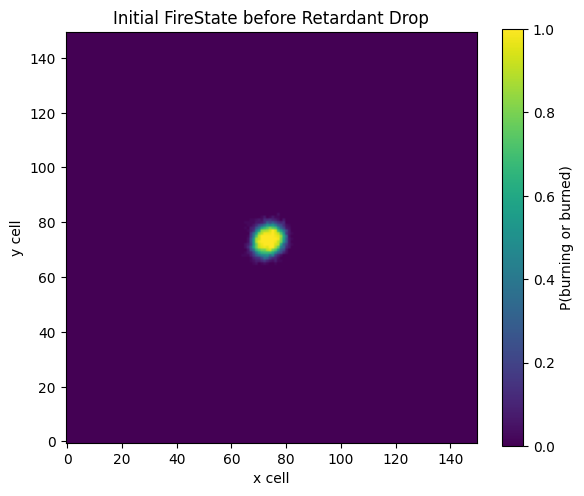

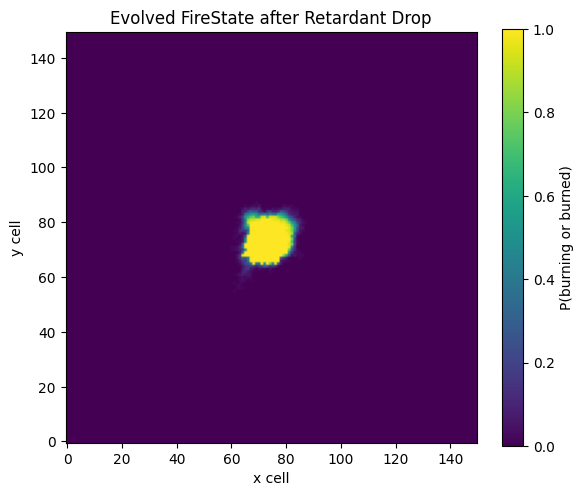

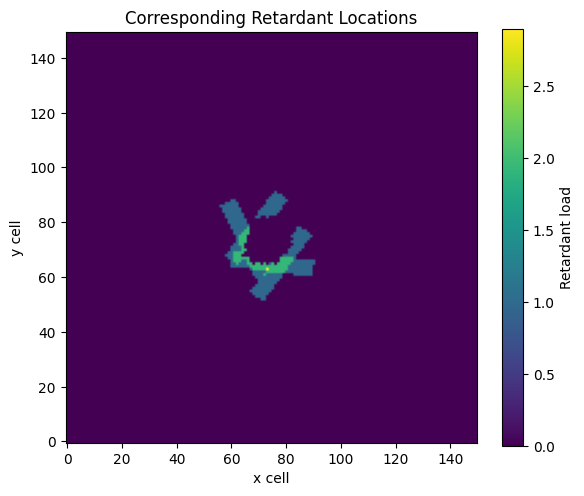

In [10]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)